In [1]:
from cortexlib.utils.file import read_json_file_as_dataframe

# For each layer, results has an FEV score for predicting neural data from SimCLR features reduced to N PCs
# Load results and filter the best FEV per layer (e.g. feats reduced to optimal number of PCs)
fev_results = read_json_file_as_dataframe('../regressions/results/simclr_feats_pcs_to_neural_data.json')
best_fev_per_layer = fev_results.loc[fev_results.groupby("layer")["mean_fev"].idxmax()]

best_fev_per_layer

,layer,n_pcs,test_r2,mean_fev
37,fc,10.0,0.017885,0.112693
2,layer1,20.0,0.026780,0.127222
9,layer2,NaN,0.030758,0.177962
26,layer3,500.0,0.035916,0.157459
27,layer4,NaN,0.022729,0.112540


In [2]:
import torch
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    simclr_data = torch.load('../regressions/features/simclr_features_all_layers.pt')

simclr_feats = simclr_data['features']

In [3]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    neural_data = torch.load('../regressions/neural_data/neural_responses_mean.pt')

neural_responses_mean = neural_data['neural_responses_mean']

In [4]:
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

# TODO: compose into an RSA class

def compute_rdm(X, metric='correlation'):
    return squareform(pdist(X, metric=metric))

def vectorise_rdm(rdm):
    triu_idx = np.triu_indices(rdm.shape[0], k=1)
    return rdm[triu_idx]

# Compute neural RDM once
rdm_neural = compute_rdm(neural_responses_mean)
vec_neural = vectorise_rdm(rdm_neural)

rsa_results = []

for layer, feats in simclr_feats.items():
    if feats.dim() > 2:
        feats = feats.view(feats.size(0), -1)
    feats = feats.numpy()
    
    for n_pcs in [None, 10, 20, 50, 100, 200, 300, 400, 500]:
        feats_pca = feats if n_pcs is None else PCA(n_pcs).fit_transform(feats)

        rdm_simclr = compute_rdm(feats_pca)
        vec_simclr = vectorise_rdm(rdm_simclr)

        sim = spearmanr(vec_neural, vec_simclr).correlation
        
        rsa_results.append({
            'layer': layer,
            'n_pcs': n_pcs,
            'spearman_correlation': sim,
        })

In [5]:
from cortexlib.utils.file import write_json_file

write_json_file(rsa_results, './results/rsa_simclr_feats_pcs_vs_neural_data.json')

In [9]:
rsa_results_df = pd.DataFrame(rsa_results)

best_rsa_per_layer = rsa_results_df.loc[
    rsa_results_df.groupby('layer')['spearman_correlation'].idxmax()
].reset_index(drop=True)

best_rsa_per_layer

,layer,n_pcs,spearman_correlation
0,fc,500.0,0.154254
1,layer1,20.0,0.185811
2,layer2,50.0,0.197980
3,layer3,NaN,0.193069
4,layer4,500.0,0.144675


In [10]:
merged_results = pd.merge(best_fev_per_layer, best_rsa_per_layer, on='layer')
merged_results

,layer,n_pcs_x,test_r2,mean_fev,n_pcs_y,spearman_correlation
0,fc,10.0,0.017885,0.112693,500.0,0.154254
1,layer1,20.0,0.026780,0.127222,20.0,0.185811
2,layer2,NaN,0.030758,0.177962,50.0,0.197980
3,layer3,500.0,0.035916,0.157459,NaN,0.193069
4,layer4,NaN,0.022729,0.112540,500.0,0.144675


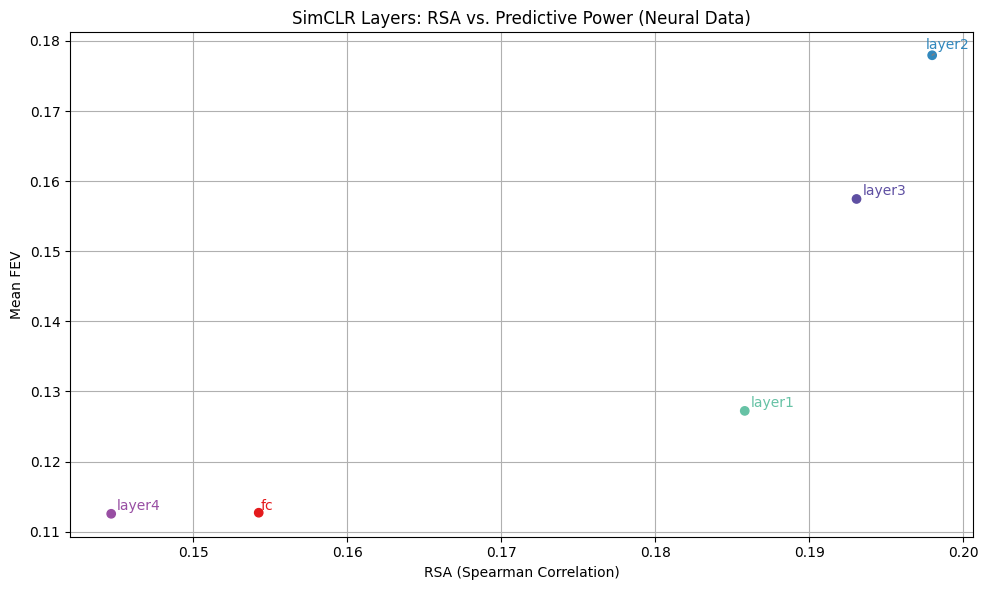

In [11]:
import matplotlib.pyplot as plt
from cortexlib.utils.plotting import simclr_colours
from adjustText import adjust_text

# TODO: compose into plotting function

colours = merged_results['layer'].map(simclr_colours)

plt.figure(figsize=(10, 6))
plt.scatter(merged_results['spearman_correlation'], merged_results['mean_fev'], c=colours)

texts = []
for _, row in merged_results.iterrows():
    texts.append(
        plt.text(row['spearman_correlation'], row['mean_fev'], row['layer'],
                 color=simclr_colours[row['layer']], fontsize=10)
    )

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'))

plt.xlabel('RSA (Spearman Correlation)')
plt.ylabel('Mean FEV')
plt.title('SimCLR Layers: RSA vs. Predictive Power (Neural Data)')
plt.grid(True)
plt.tight_layout()
plt.show()